# Histograma puntos visitante
Esta prácticaca consiste en utilizar PySpark para tratar datos procedentes del
fichero nba y construir un histograma con los puntos del equipo visitante, sin 
utilizar las funciones habituales de Python de histogramas (sns.distplot)

En primer lugar, instalamos y configuramos Spark y definimos
el contexto Spark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [2]:
sc.getConf() # Vemos que el contexto está bien definido

Importamos las librerías

In [ ]:
import pandas as pd 
import seaborn as sns

# Lectura de los datos

Podemos comenzar utilizando `spark.read.csv()` para tener una vista previa de 
los datos con los que vamos a trabajar

In [4]:
nba_csv = spark.read.csv('partidosLigaNBA.csv', header=True, sep=':')

In [ ]:
spark.read.csv?

In [5]:
nba_csv.show()

+-----------------+----------+--------------------+---+--------------------+-----+
|             Date|Start..ET.|     Visitor.Neutral|PTS|        Home.Neutral|PTS.1|
+-----------------+----------+--------------------+---+--------------------+-----+
|Tue, Oct 30, 2007|   7:30 pm|           Utah Jazz|117|Golden State Warr...|   96|
|Tue, Oct 30, 2007|   7:30 pm|     Houston Rockets| 95|  Los Angeles Lakers|   93|
|Tue, Oct 30, 2007|   7:00 pm|Portland Trail Bl...| 97|   San Antonio Spurs|  106|
|Wed, Oct 31, 2007|   8:00 pm|    Dallas Mavericks| 92| Cleveland Cavaliers|   74|
|Wed, Oct 31, 2007|   8:30 pm| Seattle SuperSonics|103|      Denver Nuggets|  120|
|Wed, Oct 31, 2007|   7:00 pm|  Washington Wizards|110|      Indiana Pacers|  119|
|Wed, Oct 31, 2007|   7:00 pm|   San Antonio Spurs|104|   Memphis Grizzlies|  101|
|Wed, Oct 31, 2007|   7:30 pm|       Chicago Bulls|103|     New Jersey Nets|  112|
|Wed, Oct 31, 2007|   7:00 pm|    Sacramento Kings| 90| New Orleans Hornets|  104|
|Wed

Solo nos interesan la tercera y cuarta columna, que contienen los nombres de 
los visitantes y los puntos que han metido

En primer lugar, convertimos a RDD, la estructura básica de 
Spark, el fichero previamente subido

In [6]:
nba_rdd = sc.textFile('partidosLigaNBA.csv')

Los rdd son transformación, no devuelven nada, utilizan evaluación perezosa (lazy evalaution) Para comprobar que los datos son correctos, aplicamos una 
acción sobre el rdd, por ejemplo un `.take(5)`


In [7]:
nba_rdd.take(5) # El fichero está separado con ":"

['Date:Start..ET.:Visitor.Neutral:PTS:Home.Neutral:PTS.1',
 'Tue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96',
 'Tue, Oct 30, 2007:"7:30 pm":Houston Rockets:95:Los Angeles Lakers:93',
 'Tue, Oct 30, 2007:"7:00 pm":Portland Trail Blazers:97:San Antonio Spurs:106',
 'Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74']

In [8]:
nba_rdd.map(lambda x: x.split(':')).cache().take(5)

[['Date', 'Start..ET.', 'Visitor.Neutral', 'PTS', 'Home.Neutral', 'PTS.1'],
 ['Tue, Oct 30, 2007',
  '"7',
  '30 pm"',
  'Utah Jazz',
  '117',
  'Golden State Warriors',
  '96'],
 ['Tue, Oct 30, 2007',
  '"7',
  '30 pm"',
  'Houston Rockets',
  '95',
  'Los Angeles Lakers',
  '93'],
 ['Tue, Oct 30, 2007',
  '"7',
  '00 pm"',
  'Portland Trail Blazers',
  '97',
  'San Antonio Spurs',
  '106'],
 ['Wed, Oct 31, 2007',
  '"8',
  '00 pm"',
  'Dallas Mavericks',
  '92',
  'Cleveland Cavaliers',
  '74']]

Limpiamos el rdd eliminando la cabecera de los datos


In [9]:
nba_rdd = nba_rdd.filter(lambda x: 'PTS' not in x)

Quitamos los Playoffs

In [22]:
nba_rdd = nba_rdd.filter(lambda x: 'Playoffs' not in x)

Construimos una función que devuelva solo el nombre del equipo y los puntos

In [10]:
def funcion_key_value (line):

    linea = line.split(':') # divido por ":" porque es el separador de los 
                            # datos 
    key = linea[3] # el tercer elemento contiene el nombre de los equipos

    value = int(linea[4]) # el cuarto elemento contiene los puntos, los paso a int

    return (key, value) # key: el nombre del equipo 
                        # value: los puntos que han metido como visitantes

# Aplicamos la función al rdd con un map
nba_parsed = nba_rdd.map(funcion_key_value)

Examinamos los resultados

In [11]:
nba_parsed.take(5)

[('Utah Jazz', 117),
 ('Houston Rockets', 95),
 ('Portland Trail Blazers', 97),
 ('Dallas Mavericks', 92),
 ('Seattle SuperSonics', 103)]

Buuscamos algo así, pero que en lugar del nombre del equipo tenga un identificador para ligarlo a un "bin" del histograma. Empezamos desde 70 y hacemos particiones de 10 en 10 hasta más de 130

In [70]:
def funcion_bin(value):
  value = int(value)

  if value < 70:
    return 'Bin 1'
  elif value < 80:
    return 'Bin 2'
  elif value < 90:
    return 'Bin 3'
  elif value < 100:
    return 'Bin 4'
  elif value < 110:
    return 'Bin 5'
  elif value < 120:
      return 'Bin 6'
  elif value < 130:
      return 'Bin 7'
  else:
    return 'Bin 8'

Editamos la función anterior añadiendo la nueva función

In [71]:
def funcion_key_value (line):

    linea = line.split(':') # igual que antes 

    key = funcion_bin(linea[4]) # el codificador de bins

    value = int(linea[4]) # igual que antes 
    return (key, value) # key: el nombre del equipo 
                        # value: los puntos que han metido como visitantes


# Aplicamos la función al rdd
nba_parsed = nba_rdd.map(funcion_key_value)

Examinamos el resultado

In [27]:
nba_parsed.take(5)

[('Bin 6', 117), ('Bin 4', 95), ('Bin 4', 97), ('Bin 4', 92), ('Bin 5', 103)]

Ahora hay que agrupar por las keys, usamos `reduceByKey`

In [25]:
nba_parsed.reduceByKey(lambda a, b: a + b).collect() # Esto es lo que queremos

[('Bin 6', 203003),
 ('Bin 4', 380801),
 ('Bin 5', 373969),
 ('Bin 3', 189783),
 ('Bin 7', 75120),
 ('Bin 2', 45903),
 ('Bin 1', 4809)]

In [72]:
puntos_por_key = nba_parsed.reduceByKey(lambda a, b: a + b).collect()

In [73]:
puntos_df = pd.DataFrame(puntos_por_key)
puntos_df

,0,1
0,Bin 6,203003
1,Bin 4,380801
2,Bin 8,14412
3,Bin 5,373969
4,Bin 3,189783
5,Bin 7,60708
6,Bin 2,45903
7,Bin 1,4809


Renombramos y ordenamos la columna de los bines alfabéticamente


In [74]:
puntos_df.rename(columns={0: 'Intervalo', 1: 'Puntos visitante'}, inplace=True)

In [75]:
puntos_df = puntos_df.sort_values(['Intervalo'])
puntos_df

,Intervalo,Puntos visitante
7,Bin 1,4809
6,Bin 2,45903
4,Bin 3,189783
1,Bin 4,380801
3,Bin 5,373969
0,Bin 6,203003
5,Bin 7,60708
2,Bin 8,14412


Cambio los nombres de los bin por algo más legible, en función de los puntos que han metido

In [76]:
def renombrar_bin(bin):
  if bin == 'Bin 1':
    return '< 70'
  elif bin == 'Bin 2':
    return '71-79'
  elif bin == 'Bin 3':
    return '80-89'
  elif bin == 'Bin 4':
    return '90-99'
  elif bin == 'Bin 5':
    return '100-109'
  elif bin == 'Bin 6':
    return '110-119'
  elif bin == 'Bin 8':
    return '120-129'
  else:
    return '> 129'

Aplicamos la función para cambiar el nombre

In [77]:
puntos_df.Intervalo = puntos_df.Intervalo.map(renombrar_bin)

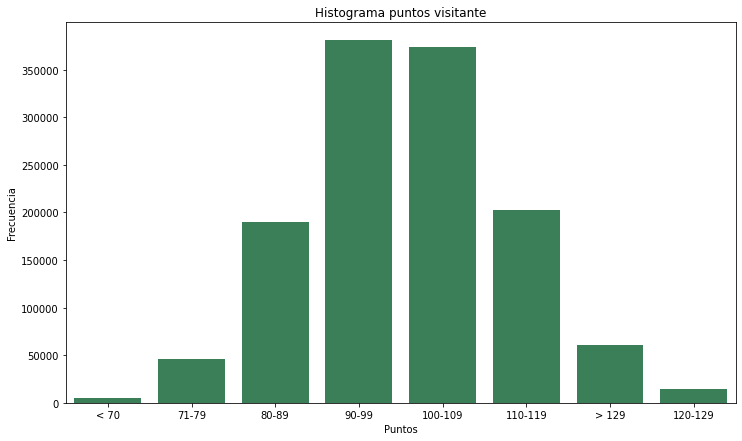

In [79]:
plt.figure(figsize=(12, 7)) # dimensiones 

sns.barplot(x='Intervalo', # en el eje x, el identificador de cada bin
            y='Puntos visitante', # en el eje y, la frecuencia
            data=puntos_df, # los datos
            color='seagreen')

# Etiquetas del plot
plt.title('Histograma puntos visitante')
plt.xlabel('Puntos')
plt.ylabel('Frecuencia');